In [15]:
import numpy as np 
from sklearn.mixture import GaussianMixture
import itertools
import pandas as pd 
import torch
import networkx as nx 
from matplotlib import pyplot as plt
import math 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.cluster import KMeans
from torch_geometric.nn import VGAE, GCNConv, SAGEConv, GraphConv
from tqdm import tqdm 
from pympler import asizeof

In [39]:
class GLMGraph:
    """
    Generate a Graph with conditional edge distribution modeled via GLM's.
    Graph should have: x, y: Node features and target
    edge_index: all edges in the graph
    pos_edge_label_index: A subset of edge index (typically half)
    neg_edge_label_index: A subset of all non-existing edges (same length as pos_edge_label_index)
    No Edge Attributes considered.
    """

    def __init__(self, n_nodes: int):

        self.Nx = None  # a NetworkX representation
        self.DataObject = None 
        
        self.n_nodes = n_nodes
        self.n_edge_permutations = int((self.n_nodes * (self.n_nodes - 1)) / 2)  # all permutations

        self.num_features = None
        self.cat_features = None # one-hot-encoded community 
        self.community_labels = None
        self.x = None
        self.y = None
        self.long_data = None

        self.edge_index = None
        self.pos_edge_label_index = None
        self.neg_edge_label_index = None

    def add_num_features(self, n_c: int, mu: list, sigma: list, w: list):
        """
        :param n_c: number of cluster components
        :param mu: list of tuples corresponding to
        num of features (tuple-length) and number of components (list-length)
        :param sigma: Covariance matrix
        :param w: mixture weights
        :return: None

        Add numeric features. Only used within the class.
        """
        assert len(mu) == len(sigma) == len(w), "Different dimensions chosen for mus, sigma, w. "

        gmm = GaussianMixture(n_components=n_c, covariance_type='full')
        # 'full': each component has its own general covariance matrix.
        gmm.means_ = np.array(mu)
        gmm.covariances_ = np.array(sigma)
        gmm.weights_ = np.array(w)
        gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covariances))

        data, _ = gmm.sample(self.n_nodes)

        self.num_features = data

    def add_community(self, k: int):
        """
        :param k: k communities
        :return: None
        """
        assert self.num_features is not None, "num_features must be instantiated."
        kmeans = KMeans(n_clusters=k, n_init=1, tol=0.1).fit(self.num_features)
        
        self.community_labels = kmeans.labels_
        self.cat_features = pd.get_dummies(kmeans.labels_).to_numpy()

    def set_x(self, ignore_cat=True):
        if self.cat_features is not None and ignore_cat == False:
            self.x = np.concatenate((self.num_features, self.cat_features), axis=1)
        else:
            self.x = self.num_features

    def set_y(self, theta: list, eps: float, task="binary", treshhold=0.5):
        """
        :param theta: model params (no intercept)
        :param eps: variance of linear relationship
        :param task: if y should be "binary","multiclass" or "regression"
        :param treshhold: float or list of uniform(0,1) numbers, 
        :return: None
        """
        if task == "regression":
            y = np.dot(self.x, theta) + np.random.normal(0, eps, self.n_nodes)
            
        if task == "binary":
            lin_rel = np.dot(self.x, theta) + np.random.normal(0, eps, self.n_nodes)
            y = (1 / (1 + np.exp(-lin_rel))) >= treshhold
        
        if task == "multiclass":
            pass
        
        self.y = y.astype(float)

    def set_connections(self, intercept, theta, eps, ignore_cat=True):
        """
        :param intercept: Base connectivity, should center the log_odds around 0
        :param theta: Model params (similar nodes should have higher coefficients)
        :param eps: model variance
        :param ignore_cat: if True: no explanatory information from communities to edged-connections 
        """
        n_rows = self.n_edge_permutations
        if self.cat_features is not None and ignore_cat == False:
            m_cols = self.cat_features.shape[1] + self.num_features.shape[1]
            # Add == loops ...

        else:
            m_cols = self.num_features.shape[1]
            long = np.zeros((n_rows, m_cols))

            for i in range(m_cols):
                xi_pairs = list(itertools.combinations(self.x[:, i], 2))
                xi_delta = [math.sqrt((pair[0] - pair[1])**2) for pair in xi_pairs] #euclidean distance
                long[:, i] = xi_delta

            colnames = [f"x{i + 1}_delta" for i in range(m_cols)]
            df_long = pd.DataFrame(long, columns=colnames)
            df_long.index = list(itertools.combinations(list(range(self.n_nodes)), 2))

        log_odds = intercept + np.dot(df_long, theta) + np.random.normal(0, eps, n_rows)
        df_long["edge_prob"] = (1 / (1 + np.exp(-log_odds))) # - 0.001
        df_long.loc[df_long['edge_prob'] == 1, 'edge_prob'] = 0.998 # avoid zero division error
        df_long.loc[df_long['edge_prob'] == 0, 'edge_prob'] = 0.001

        self.long_data = df_long

    def set_Nx(self, treshhold):
        """
        :param treshhold: a list of uniform numbers (0,1) or a float
        :return: None
        example of self.edge_index:
        tensor([[ 1,  1,  1, 48],
                [ 2,  9, 10, 49]])
        """

        node_idx = list(range(self.n_nodes))
        G = nx.Graph()
        G.add_nodes_from(node_idx,
                         size=self.num_features.sum(axis=1))

        G.add_edges_from(self.long_data[self.long_data['edge_prob'] > treshhold].index)
        edge_list = list(G.edges())

        self.Nx = G
        self.edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    def sample_train_edge_labels(self, size: int = None):
        """
        :param size: sample size of pos and neg edges
        Throws an error when not enough negative connections are established.
        """
        assert self.edge_index is not None, "No edge_indices set."

        if not size:
            size = self.n_nodes // 2

        # Positive:
        sidx_pos = np.random.choice(range(self.edge_index.shape[1]), size=size)
        self.pos_edge_label_index = self.edge_index[:, sidx_pos]

        # Negative:
        tuple_pos = set([(int(self.edge_index[0][i]),
                          int(self.edge_index[1][i]))
                         for i in range(self.edge_index.shape[1])])  # Make set of all connected node tuples
        all_permutations = set(list(itertools.combinations(list(range(self.n_nodes)), 2)))

        samp_space = np.array(list(all_permutations - tuple_pos)).T
        # print(samp_space.shape[1] + len(tuple_pos) == len(all_permutations)) # -> True
        assert samp_space.shape[1] >= size, \
            (f"Not enough negative connections to sample from. possible: {samp_space.shape[1]} | "
             f"required:{size}")

        sidx_neg = np.random.choice(range(samp_space.shape[1]), size=size)
        self.neg_edge_label_index = torch.tensor(
            samp_space[:, sidx_neg]
        )

    def set_Data_object(self):
        data = Data(x=torch.tensor(self.x, dtype=torch.float32), 
                    edge_index=self.edge_index, # allready a tensor 
                    y = torch.tensor(self.y, dtype=torch.float32),
                    pos_edge_label_index=self.pos_edge_label_index, # allready a tensor 
                    neg_edge_label_index=self.neg_edge_label_index) # allready a tensor 
        
        self.DataObject = data

    def plot_connection_details(self):
        log_odds = log_odds = np.log(self.long_data["edge_prob"] / (1 - self.long_data["edge_prob"]))

        plt.subplot(1, 2, 1)
        plt.hist(log_odds, bins=20, edgecolor='black')
        plt.title("Distribution of generated log-odds")
        plt.xlabel('Log-odds')
        plt.ylabel('Frequency')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        self.long_data["edge_prob"].hist(bins=100)
        plt.title('Histogram of Probability')
        plt.xlabel('Connection Probs')

        plt.tight_layout()
        plt.show()
    
    def plot_2d(self, main="Graph"):
        """
        Plot the Graph, with communities/target-class up to 5 categories. 
        """
        # assert self.num_features.shape[1] == 2, "Needs 2 numeric features."

        target = np.random.randint(0, 1, size=self.n_nodes)
        
        G = self.Nx
        node_idx = list(range(self.n_nodes))
        
        # Assign 2D position to each node based on features
        for i in node_idx:
            G.nodes[i]['pos'] = self.num_features[i]
            G.nodes[i]['category'] = self.community_labels[i]
            G.nodes[i]['target'] = target[i]
        
        pos = {node: data['pos'] for node, data in G.nodes(data=True)}
        color_map = {0: 'purple', 1: 'darkgreen', 2: 'gold', 3: "black", 4:"silver"} 
        shape_map = {0: 'x', 1: 'o', 2: "d", 3: "D", 4: "<"} #
        
        plt.figure(figsize=(10, 10))
        for shape in shape_map:
            nodelist = [node for node in G.nodes() if G.nodes[node]['target'] == shape]
            node_colors = [color_map[G.nodes[node]['category']] for node in nodelist]
            nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_colors, node_size=20, node_shape=shape_map[shape])
        
        nx.draw_networkx_edges(G, pos, edge_color='gray', width=.5, alpha=.1)
        
        plt.title(main)
        plt.axis('off')  
        plt.show()
        
    def clear_memory(self, all=False):
        """
        Should only be used, when Nx and Data object haven been constructed. 
        """
    
        if all:
            self.community_labels = None
            self.num_features = None
            
        self.n_edge_permutations = None
        self.cat_features = None # one-hot-encoded community 
        
        self.x = None
        self.y = None
        self.long_data = None

        self.edge_index = None
        self.pos_edge_label_index = None
        self.neg_edge_label_index = None
        
        
    def get_graph_statistics(self):
        pass
    

### Generate Graphs

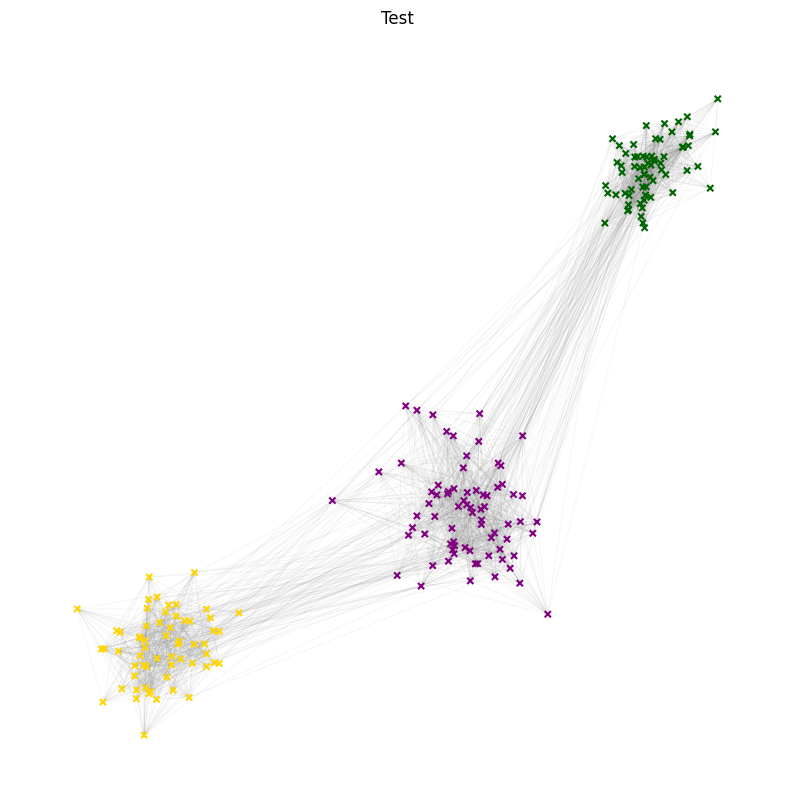

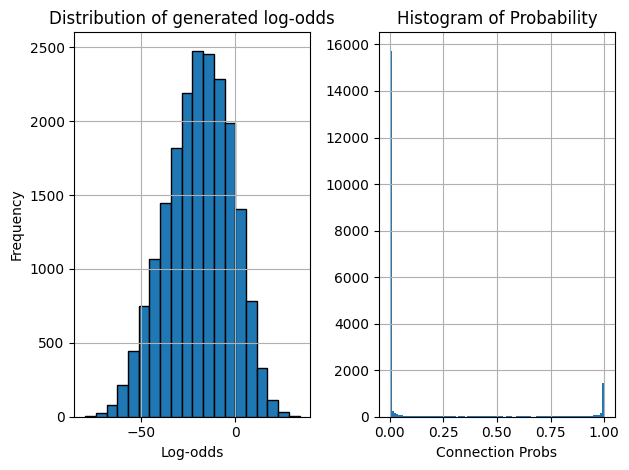

In [58]:
# ************************************************
# ********* Set Distribution Parameters: *********
# ************************************************
# I.e. Scenario:

means = [(-2, 1),
         (5, 4),
         (9, 11)]

covariances = [np.array([[0.5, 0.1],
                         [0.1, 0.5]]),
               np.array([[0.8, -0.2],
                         [-0.2, 0.8]]),
               np.array([[0.3, 0.1],
                         [0.1, 0.3]])]

weights = [0.3, 0.4, 0.3]

k = 3

y_theta = [1.5, 3]

c_intercept = 0
c_theta = [-2.5, -1.5]
n_nodes = 200

# ************************************************
# ********* Set MC-variance: *********************
# ************************************************

y_eps = 3
c_eps = 10
R = 20 # Number of MC-runs


def gen_graph(n_nodes, clear=True):
    """ Adjusted to workflow order"""
    gglm = GLMGraph(n_nodes)
    
    gglm.add_num_features(n_c=3, mu=means, sigma=covariances, w=weights)
    gglm.add_community(k)
    gglm.set_x(ignore_cat=True)
    gglm.set_y(y_theta, y_eps, task="binary")
    
    gglm.set_connections(c_intercept, c_theta, c_eps, ignore_cat=True)
    th = np.random.rand(gglm.n_edge_permutations) #treshhold
    gglm.set_Nx(th)
    
    gglm.sample_train_edge_labels()
    gglm.set_Data_object()
    
    if clear:
        gglm.clear_memory() # leaves only Nx and DataObject 

    return gglm

sampG = gen_graph(200, False)
sampG.plot_2d("Test")
sampG.plot_connection_details()

In [59]:
train_data_list, val_data_list, test_data_list = [], [], []

n_train = math.floor(0.8 * R)
n_test = math.floor(0.15 * R)
n_val = math.floor(0.05 * R)

split_select = np.concatenate((np.repeat(1, n_train),
                               np.repeat(2, n_test),
                               np.repeat(3, n_val)))


# Assign generated graph to test, train or val
while split_select.size > 0:
    graph = gen_graph(n_nodes)
    random_draw = np.random.randint(0, split_select.size)
    x = split_select[random_draw]
    if x == 1:
        train_data_list.append(graph)
    if x == 2:
        test_data_list.append(graph)
    if x == 3:
        val_data_list.append(graph)
        
    split_select = np.delete(split_select, random_draw)

### Build VGAE

In [60]:
# Network architecture: *****************************************************
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        """
        :param x: Node features 
        :param edge_index: connection information
        :return: a tuple of 2 tensors of size out_channel
        """
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index) # ([16,16])

in_channels, out_channels, lr = 2, 16, 1e-2
gen_graphs, threshold, add_self_loops = 5, 0.5, True
# Parameters of VGAE: Encoder (with its parameters) and optional(!) decoder.
# self.decoder = InnerProductDecoder() if decoder is None else decoder.
model = VGAE(encoder=VariationalGCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train():
    """
    :return: Avg Train Loss for one epoch
    called in the train Loop
    One entire graph is processed at a time 
    """
    model.train()
    loss_all = 0
    #batch_iteration = 0
    for data in train_loader:
        optimizer.zero_grad()
        # model is an instance of the VGAE class.
        # The layers and forward method where passed as inputs to VGAE().
        # def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        # if self.training:
        #    return mu + torch.randn_like(logstd) * torch.exp(logstd)
        # else:
        #    return mu
        z = model.encode(data.x, data.edge_index) # only one tensor due to re-parametrize  
        
        # reconstruction loss: use both postive and negative samples (nodes with and without edges)
        # since we want to predict both outcomes: edge or no edge
        loss = model.recon_loss(z, data.pos_edge_label_index, data.neg_edge_label_index)
        loss = loss + .01 * model.kl_loss()
        loss.backward()
        loss_all += data.y.size(0) * float(loss) # (variable) batch size * loss
        optimizer.step()
        #batch_iteration += 1
        #print("batch-iteration: ", batch_iteration)
        
    avg_loss = loss_all / len(train_loader.dataset)
    print(avg_loss)
    

    return avg_loss

@torch.no_grad()
def val(loader):
    model.eval()
    auc_all, ap_all = 0, 0

    for data in loader:
        z = model.encode(data.x, data.edge_index)
        auc, ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
        auc_all += data.y.size(0) * float(auc) # ???
        ap_all += data.y.size(0) * float(ap) # ???
    return auc_all / len(val_loader.dataset), ap_all / len(val_loader.dataset)


In [61]:
# Original Setup: 
#train_loader = DataLoader(train_data_list, batch_size=100, shuffle=True)
#val_loader = DataLoader(val_data_list, batch_size=4, shuffle=True)
#n_epochs = 5

train_loader = DataLoader([graph.DataObject for graph in train_data_list], batch_size=10, shuffle=True)
val_loader = DataLoader([graph.DataObject for graph in val_data_list], batch_size=10, shuffle=True)
n_epochs = 40

In [62]:
for epoch in range(1, n_epochs + 1):
    loss = train()
    auc, ap = val(val_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}')

118845349.21875
Epoch: 001, Loss: 118845349.2188, AUC: 131.7200, AP: 118.9618
4377547.784423828
Epoch: 002, Loss: 4377547.7844, AUC: 132.5800, AP: 119.5157
11545.28455734253
Epoch: 003, Loss: 11545.2846, AUC: 133.4800, AP: 120.2478
3900.405216217041
Epoch: 004, Loss: 3900.4052, AUC: 132.8500, AP: 119.7475
3509.512424468994
Epoch: 005, Loss: 3509.5124, AUC: 129.3300, AP: 116.8203
3428.17645072937
Epoch: 006, Loss: 3428.1765, AUC: 129.1700, AP: 116.7567
3373.1823921203613
Epoch: 007, Loss: 3373.1824, AUC: 129.0700, AP: 116.7164
3294.4172382354736
Epoch: 008, Loss: 3294.4172, AUC: 129.0900, AP: 116.7212
3223.477363586426
Epoch: 009, Loss: 3223.4774, AUC: 128.6000, AP: 116.2678
3127.8780937194824
Epoch: 010, Loss: 3127.8781, AUC: 126.7000, AP: 114.5578
2896.6893434524536
Epoch: 011, Loss: 2896.6893, AUC: 122.6400, AP: 110.6894
2360.9155893325806
Epoch: 012, Loss: 2360.9156, AUC: 122.8000, AP: 112.6776
1187.5873804092407
Epoch: 013, Loss: 1187.5874, AUC: 141.4600, AP: 129.5990
530.580729246

## Sample new Graphs

In [74]:
def sample_from_rand(size):
    """ 
    1. Get Adj. Matrix 
    2. 
    """
    n = size
    z_draw = torch.rand(n, out_channels) # this draw might be faulty 
    model.eval()
    A = model.decoder.forward_all(z_draw).numpy() > .5
    A[np.arange(n), np.arange(n)] = 0 #remove self.loops
    
    newG = gen_graph(200)
    newG.plot_2d("New Generated")
    newG.Nx.clear_edges()
    
    indices = np.nonzero(A)
    edges = zip(indices[0], indices[1])
    newG.Nx.add_edges_from(edges)
    newG.plot_2d("Synthetic edges")

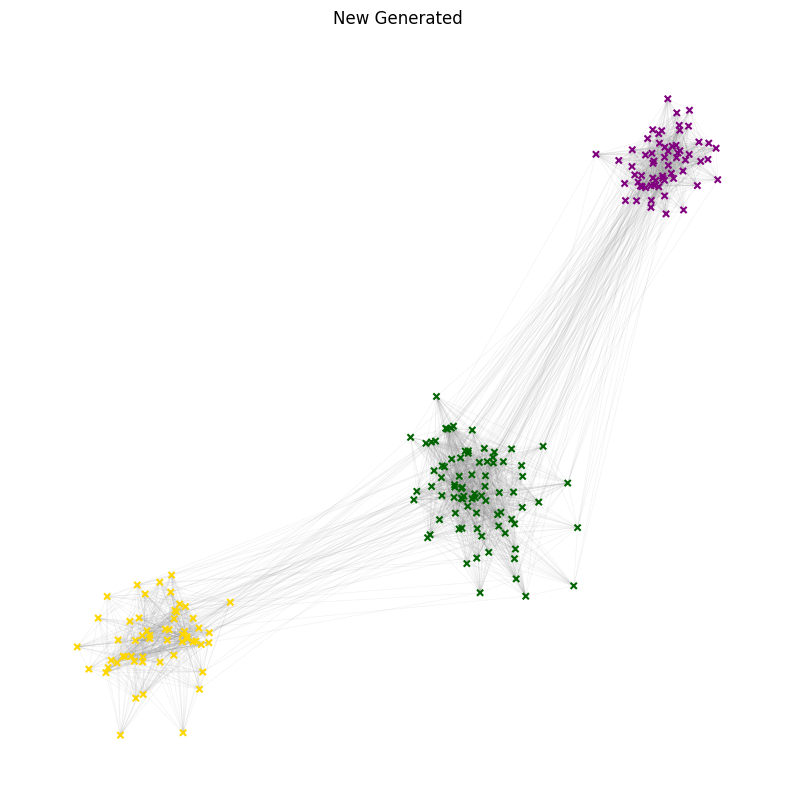

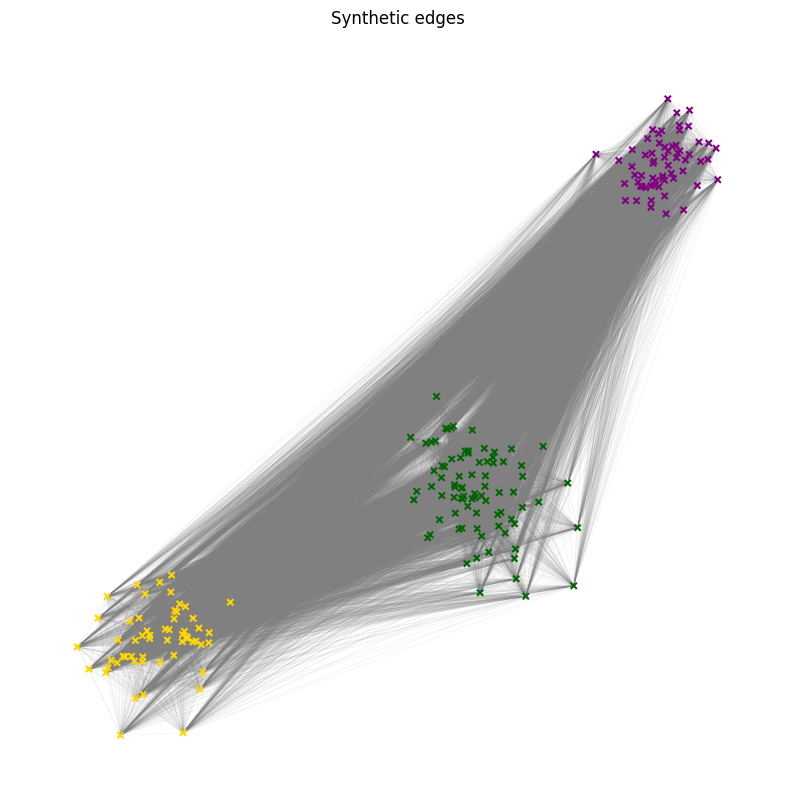

In [75]:
sample_from_rand(200)

## Sample test graphs 

In [71]:
@torch.no_grad()
def sample_from_test(graph):
    
    data = graph.DataObject
    model.eval()
    z = model.encode(data.x, data.edge_index)
    #th = np.random.uniform(low=0.0, high=1.0, size=(200, 200))
    A = model.decoder.forward_all(z, sigmoid=True).detach().numpy() > .5 #th
    A[np.arange(200), np.arange(200)] = 0
    
    graph.plot_2d("Orginal")
    graph.Nx.clear_edges()
    indices = np.nonzero(A)
    edges = zip(indices[0], indices[1])
    
    graph.Nx.add_edges_from(edges)
    graph.plot_2d("Synthetic")


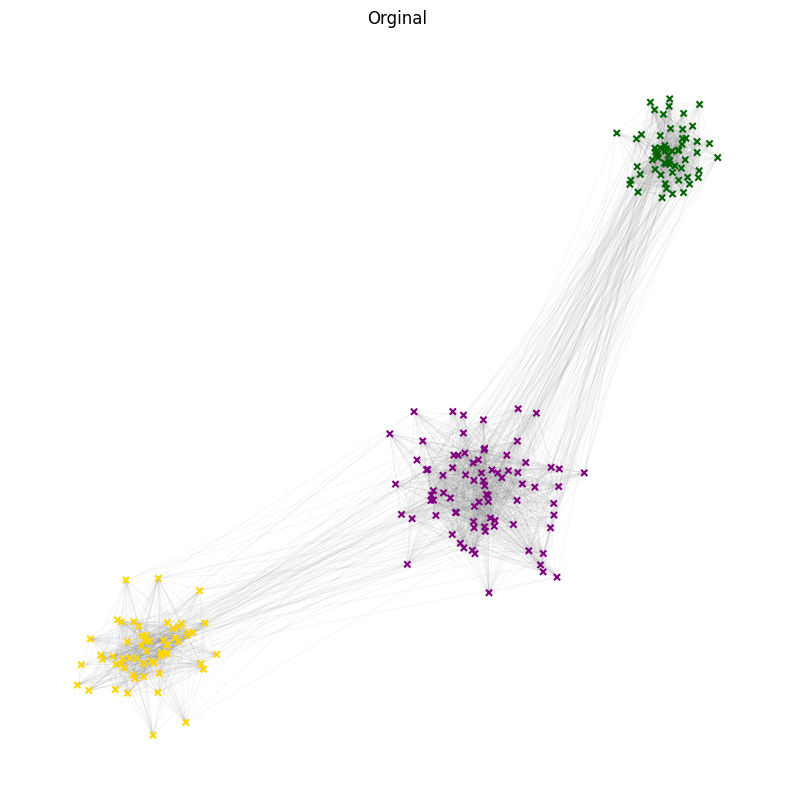

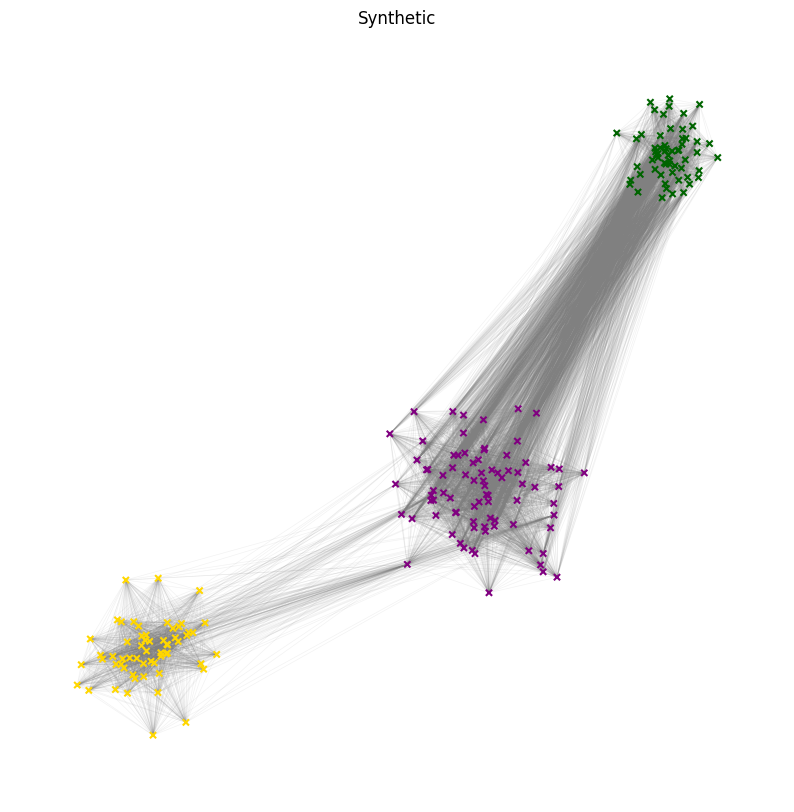

In [72]:
sample_from_test(gen_graph(200))

## Plotting

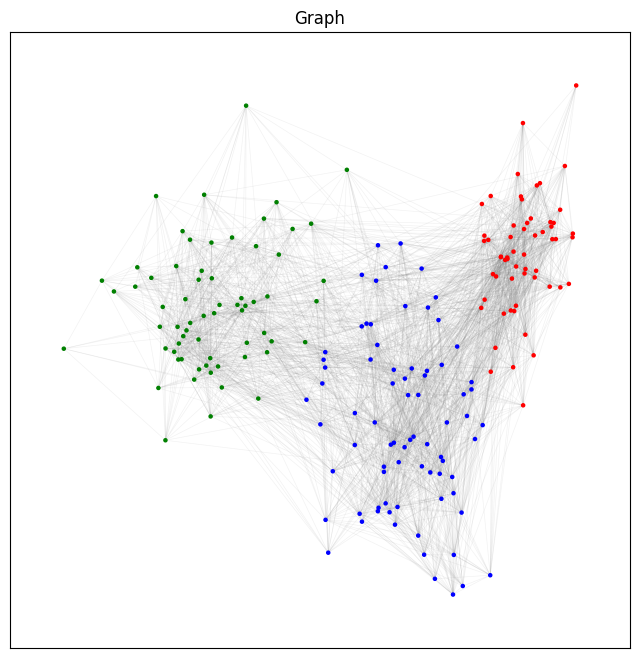

In [134]:
n_nodes = 200
gglm = gen_graph(n_nodes)
features = gglm.num_features #np.random.rand(n_nodes, 2)
categories = gglm.community_labels

G = gglm.Nx
node_idx = list(range(n_nodes))

# Assign 2D position to each node based on features
for i in node_idx:
    G.nodes[i]['pos'] = features[i]
    G.nodes[i]['category'] = categories[i]


# Extract positions
pos = {node: data['pos'] for node, data in G.nodes(data=True)}
color_map = {0: 'red', 1: 'green', 2: 'blue'}

node_colors = [color_map[G.nodes[i]['category']] for i in G.nodes()]


plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=.5, alpha=.1)

plt.title('Graph')
plt.axis('on')  
plt.show()

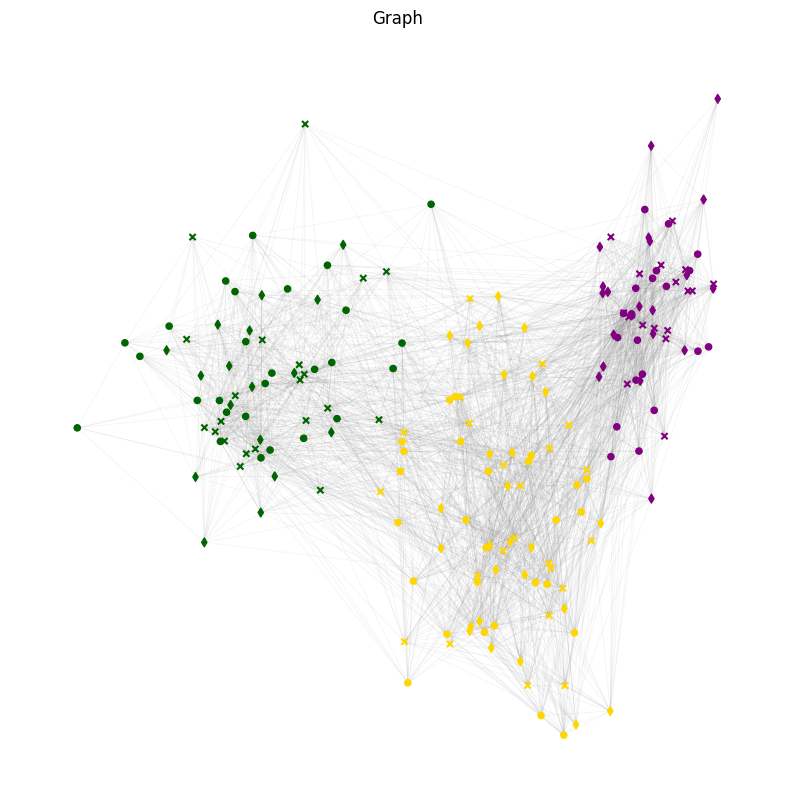

In [139]:
n_nodes = 200
features = gglm.num_features 
categories = gglm.community_labels 
target = np.random.randint(0, 3, size=n_nodes)

G = gglm.Nx
node_idx = list(range(n_nodes))

# Assign 2D position to each node based on features
for i in node_idx:
    G.nodes[i]['pos'] = features[i]
    G.nodes[i]['category'] = categories[i]
    G.nodes[i]['target'] = target[i]

pos = {node: data['pos'] for node, data in G.nodes(data=True)}
color_map = {0: 'purple', 1: 'darkgreen', 2: 'gold', 3: "black", 4:"silver"} # add more, for higher k 
shape_map = {0: 'x', 1: 'o', 2: "d", 3: "d"} #

plt.figure(figsize=(10, 10))
for shape in shape_map:
    nodelist = [node for node in G.nodes() if G.nodes[node]['target'] == shape]
    node_colors = [color_map[G.nodes[node]['category']] for node in nodelist]
    nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_colors, node_size=20, node_shape=shape_map[shape])

nx.draw_networkx_edges(G, pos, edge_color='gray', width=.5, alpha=.1)

plt.title('Graph')
plt.axis('off')  
plt.show()